In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report)
import optuna
import mlflow
import mlflow.xgboost
import pickle
from xgboost import XGBClassifier


In [4]:
# Load the dataset
df = pd.read_csv('data.csv')

# Separate features and target
X = df.drop('FraudResult', axis=1)
y = df['FraudResult']

# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [5]:
# Initialize MLflow
mlflow.set_experiment("Fraud_Detection_XGBoost")

def print_confusion_matrix(y_true, y_pred):
    """Print a formatted confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()


2025/07/02 14:16:36 INFO mlflow.tracking.fluent: Experiment with name 'Fraud_Detection_XGBoost' does not exist. Creating a new experiment.


In [6]:

def objective(trial):
    """Simplified objective function for Optuna optimization"""

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=20),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.1, 0.5, 0.01, 0.05]),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_categorical('gamma', [0, 0.5, 1, 0.1, 5]),
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.5, 1, 5, 10]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0, 0.5, 1, 5, 10]),
        'random_state': 42
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)


In [7]:
def train_and_log_best_model(best_params):
    """Train and log the best model with MLflow"""

    with mlflow.start_run(run_name="Best_XGBoost_Model"):
        model = XGBClassifier(**best_params)
        model.fit(X_train, y_train)

        with open('model.pkl', 'wb') as f:
            pickle.dump(model, f)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba)
        }

        # Log parameters and metrics
        mlflow.log_params(best_params)
        mlflow.log_metrics(metrics)
        mlflow.xgboost.log_model(model, "model")

        # Generate and log feature importance
        importance = model.get_booster().get_score(importance_type='weight')
        importance_df = pd.DataFrame({
            'feature': list(importance.keys()),
            'importance': list(importance.values())
        }).sort_values('importance', ascending=False)

        # Generate and log classification report
        report = classification_report(y_test, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()

        # Print results
        print("Best XGBoost model logged with MLflow")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Print confusion matrix
        print("\nConfusion Matrix:")
        print_confusion_matrix(y_test, y_pred)

        print("\nTop 10 Features by Importance:")
        print(importance_df.head(10))

[I 2025-07-02 14:16:45,095] A new study created in memory with name: no-name-226c61a1-e884-4f5a-be72-30ea6d1f20f8
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 290].
  warnings.warn(
[I 2025-07-02 14:16:45,513] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.6711598915151954, 'colsample_bytree': 0.7474647956923203, 'gamma': 5, 'reg_alpha': 10, 'reg_lambda': 10}. Best is trial 0 with value: 0.0.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 290].
  warnings.warn(
[I 2025-07-02 14:16:46,393] Trial 1 finished with value: 0.5671641791044776 and parameters: {'n_estimators': 210, 'max_depth': 5, 'le


Best trial:
Best F1 Score: 0.7297
Best Params: {'n_estimators': 130, 'max_depth': 13, 'learning_rate': 0.5, 'subsample': 0.7495122822323312, 'colsample_bytree': 0.9339528436871868, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}


2025/07/02 14:23:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:23:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/07/02 14:23:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best XGBoost model logged with MLflow

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19097
           1       0.67      0.72      0.69        36

    accuracy                           1.00     19133
   macro avg       0.83      0.86      0.85     19133
weighted avg       1.00      1.00      1.00     19133


Confusion Matrix:


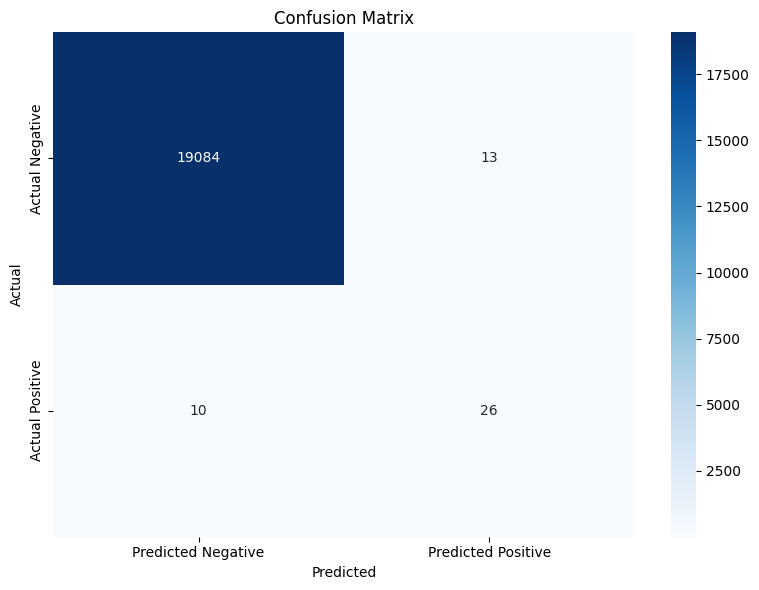


Top 10 Features by Importance:
             feature  importance
4     TransactionDay       797.0
3    TransactionHour       731.0
7         ProviderId       285.0
5   TransactionMonth       198.0
0             Amount       147.0
1              Value        80.0
2    PricingStrategy        70.0
9    ProductCategory        28.0
8          ProductId        28.0
10         ChannelId        14.0


In [8]:
def main():
    # Optuna optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=400)

    # Print best trial
    print("\nBest trial:")
    trial = study.best_trial
    print(f"Best F1 Score: {trial.value:.4f}")
    print("Best Params:", trial.params)

    # Train and log the best model
    train_and_log_best_model(trial.params)

if __name__ == "__main__":
    main()